In [1]:
from fenics import *
import numpy as np

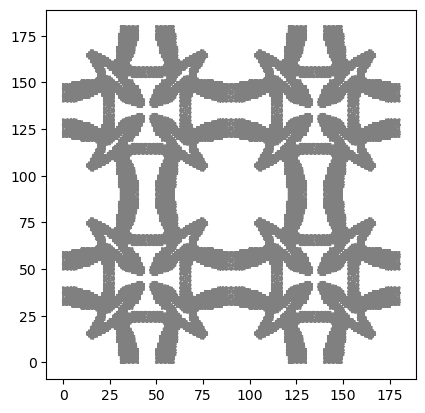

In [2]:
import os;
import matplotlib.pyplot as plt
# path = './'
mesh = Mesh('./xml/mesh.xml');
plot(mesh)
materials = MeshFunction("size_t", mesh, "./xml/materials.xml")


In [3]:
class ElasticityParameter(UserExpression):
    def __init__(self, materials, E1, E2, nu, beta1, beta2, parameter_type, **kwargs):
        super().__init__(**kwargs)
        self.materials = materials
        self.E1 = E1
        self.E2 = E2
        self.nu = nu
        self.beta1 = beta1
        self.beta2 = beta2
        self.parameter_type = parameter_type


    def eval_cell(self, values, x, cell):
        material_type = self.materials[cell.index]
        if self.parameter_type == 'beta':
            values[0] = self.beta1 if material_type == 0 else self.beta2
        elif self.parameter_type == 'mu':
            E = self.E1 if material_type == 0 else self.E2
            values[0] = E / (2 * (1 + self.nu))
        elif self.parameter_type == 'lambda':
            E = self.E1 if material_type == 0 else self.E2
            values[0] = E * self.nu / ((1 + self.nu) * (1 - 2 * self.nu))
    def value_shape(self):
        return ()

In [4]:
V = VectorFunctionSpace(mesh, 'P', 1)

# Elasticity parameters
E1, E2, nu = 1, 1, 0.3  # example values
beta1,beta2 = 1.,10
mu = ElasticityParameter(materials, E1, E2, nu, beta1, beta2, 'mu', degree=0)
lambda_ = ElasticityParameter(materials, E1, E2, nu, beta1, beta2, 'lambda', degree=0)
beta = ElasticityParameter(materials, E1, E2, nu, beta1, beta2, 'beta', degree=0)


In [5]:
delta_T = 1
def epsilon(u):
    return sym(grad(u))
def sigma(u,delta_T):
    # return lambda_ * tr(epsilon(u)) * Identity(len(u)) + 2 * mu * epsilon(u) - beta * (3*lmbda_+2*mu)*delta_T)*Identity(2)
    return (lambda_*tr(epsilon(u))- beta*(3*lambda_+2*mu)*delta_T)*Identity(2) + 2.0*mu*epsilon(u)
    

In [6]:
coordinates = mesh.coordinates()

# Find the minimum x and y coordinates
x_min = min(coordinates[:, 0])
y_min = min(coordinates[:, 1])

def left_boundary(x, on_boundary):
    return near(x[0], x_min) and on_boundary

def bottom_boundary(x, on_boundary):
    return near(x[1], y_min) and on_boundary

bc_left = DirichletBC(V.sub(0), Constant(0), left_boundary)   # ux = 0 at left boundary
bc_bottom = DirichletBC(V.sub(1), Constant(0), bottom_boundary) # uy = 0 at bottom boundary

# bc = DirichletBC(V, Constant((0., 0.)), left_boundary)
bc =  [bc_left, bc_bottom]

# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)

# Define variational problem
a = inner(sigma(u,delta_T), epsilon(v)) * dx
# L = Constant((0, 0)) * v * dx  # Assuming no body forces
L = inner(Constant((0, 0)), v) * dx

# Compute solution
u = Function(V, name="Displacement")

solve(lhs(a) == rhs(a) + L, u, bc)


Solving linear variational problem.


In [7]:
# Plot solution
%matplotlib
plot(0.007*u, mode="displacement")
plot(mesh, alpha=0.5)


Using matplotlib backend: MacOSX
Object cannot be plotted directly, projecting to piecewise linears.


In [8]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np

# Get the coordinates of the mesh nodes
coordinates = mesh.coordinates()
x = coordinates[:, 0]
y = coordinates[:, 1]

# Create a triangulation object
triangulation = tri.Triangulation(x, y, mesh.cells())

# Plot the mesh function using trisurf
plt.figure()
plt.tripcolor(triangulation, materials.array(), shading='flat')
plt.colorbar()
plt.title('Material Distribution')
plt.show()


In [9]:
# Assuming 'materials' is your MeshFunction
material_values = materials.array()
unique_materials = np.unique(material_values)
print("Unique material indices:", unique_materials)

# If the material indices are not as expected, you need to revisit how 'materials' is initialized.


Unique material indices: [0 1]


In [10]:
# # Assuming 'mesh' is your Mesh object and 'materials' is the MeshFunction
# for cell in cells(mesh):
#     # Print material properties for the first few cells as a check
#     if cell.index() < 100:  # Adjust the range as needed
#         print(f"Cell index: {cell.index()}, Material ID: {materials[cell.index()]}")
